## Sequential sentence classification task,
### Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature and dive deeper when necessary.

### This ANN model consists of three components: a hybrid token embedding layer, a sentence label prediction layer, and a label sequence optimization layer.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [3]:
# data_dir =  "../input/200000-abstracts-for-seq-sentence-classification/20k_abstracts_numbers_with_@/"
data_dir = 'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [4]:
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [5]:
# Create function to read the lines of a document
def get_lines(filename):
    """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
    with open(filename,'r') as f:
        return f.readlines()

In [6]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
def preprocess_text_with_line_numbers(filename):
    """Returns a list of dictionaries of abstract line data.
    
    Takes in Filename,reads its content and sorts through each line,
    extracting things like target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence 
    number the target line is.
    
     Args:
      filename: a string of the target text file to read and extract line 
      data from
      
     Returns:
     A list of dictionaries each containing a line from an abstract,
     the lines label,the line position in the abstract and the total number 
     of lines in the abstract where the line is from, For example:
     
     [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
    """
    input_lines = get_lines(filename)
    abstract_lines = ""  # create an empty abstract
    abstract_samples = []  # create an empty list of abstracts
    
    # Loop through each line in target file
    for line in input_lines:
        if line.startswith('###'):
            abstract_id = line
            abstract_lines = "" # reset abstract string
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
            
            # Iterate through each line in abstract and count them at the same time
            for abstract_line_number,abstract_line in enumerate(abstract_line_split):
                line_data = {} # create empty dict to store data from line
                target_text_split = abstract_line.split('\t') # split target label from text
                line_data['target'] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it
                line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract?
                line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
                abstract_samples.append(line_data)
        
        else:abstract_lines += line
            
    return abstract_samples        

In [8]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [9]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [10]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [11]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64


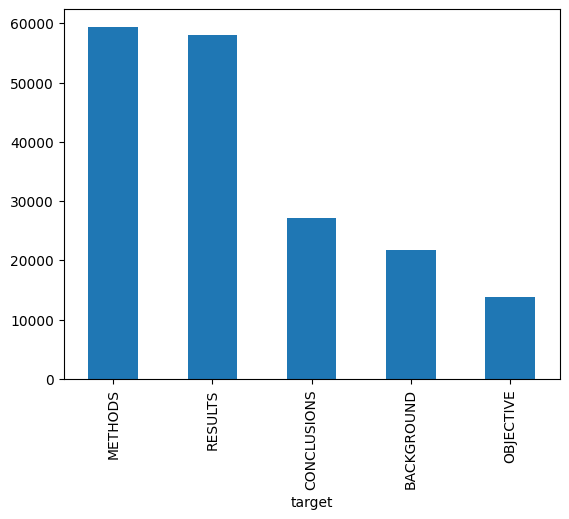

In [12]:
# Distribution of labels in training data
print(train_df.target.value_counts())
train_df.target.value_counts().plot.bar();

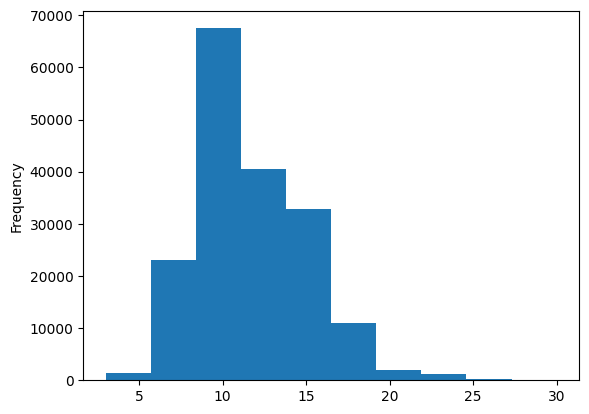

In [13]:
train_df.total_lines.plot.hist(); # Most of the abstracts are around 7 to 15 sentences in length.

In [14]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

### One hot encode labels

In [16]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [17]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes from LabelEncoder instance 
class_names = label_encoder.classes_
num_classes = len(label_encoder.classes_)
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a series of model experiments

## Model 0: Getting a baseline

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,y=train_labels_encoded);

In [20]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,y=val_labels_encoded)

0.7218323844829869

In [21]:
# Make predictions
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

def calculate_results(y_true,y_pred):
    """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted la_bels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
    # Calculate model accuracy
    model_accuracy=accuracy_score(y_true,y_pred)*100
    # Calculate model precision, recall and f1 score using "weighted" average
    model_precision,model_recall,model_f1,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1-score": model_f1}
    
    return model_results

In [23]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1-score': 0.6989250353450294}

## Preparing data for deep sequence models

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [25]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

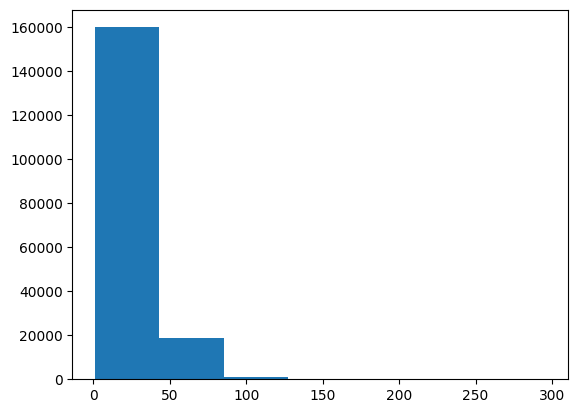

In [26]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=7);

In [27]:
# Maximum sentence length in the training set
max(sent_lens)

296

In [28]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

## Create text vectorizer

In [29]:
max_tokens = 68000
max_token_length = 55

In [30]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                output_sequence_length=max_token_length)  # desired output length of vectorized sequences

In [31]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [32]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n {text_vectorizer([target_sentence])}")

Text:
 correlations among levels in serum , erythrocyte , and whole blood were stronger for cobalt than for chromium .

Length of text: 19

Vectorized text:
 [[ 2378   116    93     5   225  3201     3  1300   107     9  3186    11
  16160    42    11 10828     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [33]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


## Create custom text embedding

In [34]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),# length of vocabulary
                              output_dim=256,
                              mask_zero=True, # Use masking to handle variable sequence lengths (save space)
                              name="token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
correlations among levels in serum , erythrocyte , and whole blood were stronger for cobalt than for chromium .

Sentence after vectorization (before embedding):
[[ 2378   116    93     5   225  3201     3  1300   107     9  3186    11
  16160    42    11 10828     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.00268476  0.00881772  0.0399887  ...  0.02011422  0.01523298
    0.04902602]
  [-0.03230798  0.03153129 -0.02063596 ... -0.04016464  0.03536376
    0.00617518]
  [-0.01360141  0.00961994  0.00354253 ... -0.02357624  0.02011988
    0.04029975]
  ...
  [ 0.00351542 -0.00177373 -0.03715249 ... -0.00188937  0.01599613
   -0.0373271 ]
  [ 0.00351542 -0.00177373 -0.03715249 ... -0.00188937  0.01599613
   -0.0373271 ]
  [ 0.00351542 -0

## Create datasets 

In [35]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [36]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [37]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,),dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [38]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 256)           16599296  
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            81984     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [39]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.2*len(train_dataset)),
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(0.2*len(valid_dataset)))

Epoch 1/5

1125/1125 [==============================] - 101s 89ms/step - loss: 0.7568 - accuracy: 0.7119 - val_loss: 0.6164 - val_accuracy: 0.7751
Epoch 2/5
1125/1125 [==============================] - 104s 92ms/step - loss: 0.5907 - accuracy: 0.7873 - val_loss: 0.5606 - val_accuracy: 0.8004
Epoch 3/5
1125/1125 [==============================] - 93s 83ms/step - loss: 0.5783 - accuracy: 0.7937 - val_loss: 0.5371 - val_accuracy: 0.8112
Epoch 4/5
1125/1125 [==============================] - 87s 77ms/step - loss: 0.5425 - accuracy: 0.8074 - val_loss: 0.5203 - val_accuracy: 0.8158
Epoch 5/5
1125/1125 [==============================] - 86s 77ms/step - loss: 0.5362 - accuracy: 0.8101 - val_loss: 0.5268 - val_accuracy: 0.8132


# 

In [40]:
model_1.evaluate(valid_dataset)

  1/945 [..............................] - ETA: 9s - loss: 0.8242 - accuracy: 0.5625

945/945 [==============================] - 2s 2ms/step - loss: 0.5287 - accuracy: 0.8107


[0.5286620259284973, 0.8106712698936462]

In [41]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[6.1509365e-01, 8.9054160e-02, 8.4204823e-02, 1.5673001e-01,
        5.4917302e-02],
       [5.2544194e-01, 2.4019803e-01, 1.0284347e-02, 1.9735785e-01,
        2.6717894e-02],
       [2.3762679e-01, 8.2366420e-03, 1.2631805e-03, 7.5280178e-01,
        7.1679213e-05],
       ...,
       [3.6358058e-06, 9.9755984e-05, 1.8232507e-03, 2.3855025e-06,
        9.9807101e-01],
       [1.1606103e-01, 5.0021130e-01, 1.0860216e-01, 6.5251537e-02,
        2.0987388e-01],
       [2.6977334e-02, 9.5366281e-01, 1.6305229e-02, 8.7494525e-04,
        2.1797239e-03]], dtype=float32)

In [42]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [43]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 81.06712564543889,
 'precision': 0.807987451271682,
 'recall': 0.810671256454389,
 'f1-score': 0.8068552980006385}

## Model 2: Feature extraction with pretrained token embeddings

In [44]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       trainable=False,
                                       name="universal_sentence_encoder")

In [45]:
target_sentence = random.choice(train_sentences)
print(f"Sentence before vectorization:\n{target_sentence}\n")
embedded_sentence = tf_hub_embedding_layer([target_sentence])
print(f"Sentence after embedding:\n{embedded_sentence[0][:30]}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
these secondary effects were not consistent with any other outcomes and may have been a result of chance .

Sentence after embedding:
[ 0.00014728 -0.04475116 -0.04929148  0.00864663  0.03328985 -0.00661403
  0.02648752  0.00925593 -0.08962357  0.05101637  0.01132497 -0.0203723
 -0.00412658  0.06073507  0.03752321  0.04492912 -0.03445261 -0.04412394
 -0.02202801 -0.00725387  0.07095958  0.05212309 -0.05334245 -0.0011125
 -0.01502224  0.00504668  0.08597463  0.07870608  0.00630534  0.05453743]

Embedded sentence shape: (1, 512)


In [46]:
inputs = layers.Input(shape=[],dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(1024,activation='relu')(pretrained_embedding)
x = layers.Dense(1024,activation='relu')(x)
outputs = layers.Dense(5,activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [47]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 258377861 (985.63 MB)
Trainable params: 1580037 (6.03 MB)
Non-trainable params: 256797824 (979.61 MB)
_________

In [48]:
model_2.fit(train_dataset,
           steps_per_epoch=int(0.2*len(train_dataset)),
           epochs=5,
           validation_data=valid_dataset,
           validation_steps=int(0.2 * len(valid_dataset)))

Epoch 1/5
1125/1125 [==============================] - 11s 8ms/step - loss: 0.7572 - accuracy: 0.7067 - val_loss: 0.6700 - val_accuracy: 0.7399
Epoch 2/5
1125/1125 [==============================] - 9s 8ms/step - loss: 0.6635 - accuracy: 0.7456 - val_loss: 0.6397 - val_accuracy: 0.7541
Epoch 3/5
1125/1125 [==============================] - 9s 8ms/step - loss: 0.6548 - accuracy: 0.7499 - val_loss: 0.6091 - val_accuracy: 0.7733
Epoch 4/5
1125/1125 [==============================] - 9s 8ms/step - loss: 0.6219 - accuracy: 0.7646 - val_loss: 0.6030 - val_accuracy: 0.7708
Epoch 5/5
1125/1125 [==============================] - 9s 8ms/step - loss: 0.6156 - accuracy: 0.7644 - val_loss: 0.5929 - val_accuracy: 0.7735


In [49]:
model_2.evaluate(valid_dataset)

  1/945 [..............................] - ETA: 10s - loss: 0.9753 - accuracy: 0.5938

945/945 [==============================] - 4s 4ms/step - loss: 0.5978 - accuracy: 0.7721


[0.5977565050125122, 0.772143542766571]

In [50]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[4.49747235e-01, 3.91489327e-01, 5.13505656e-04, 1.55445933e-01,
        2.80405907e-03],
       [4.76546556e-01, 3.85348439e-01, 4.38755524e-04, 1.36480570e-01,
        1.18573185e-03],
       [3.32033813e-01, 8.94846395e-03, 5.44866361e-02, 5.94164848e-01,
        1.03662722e-02],
       ...,
       [7.87780518e-05, 4.08804044e-04, 4.27650474e-03, 3.16567748e-05,
        9.95204210e-01],
       [7.63779134e-03, 1.24333404e-01, 7.60864690e-02, 2.08634348e-03,
        7.89855897e-01],
       [6.03955705e-04, 9.99368846e-01, 2.06480963e-05, 4.29370210e-08,
        6.62123148e-06]], dtype=float32)

In [51]:
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [52]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.2143519131471,
 'precision': 0.767209960076613,
 'recall': 0.772143519131471,
 'f1-score': 0.767951317345249}

## Model 3: Conv1D with character embeddings

### Creating a character-level tokenizer

In [53]:
# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

split_chars(target_sentence)

't h e s e   s e c o n d a r y   e f f e c t s   w e r e   n o t   c o n s i s t e n t   w i t h   a n y   o t h e r   o u t c o m e s   a n d   m a y   h a v e   b e e n   a   r e s u l t   o f   c h a n c e   .'

In [54]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
valid_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [55]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

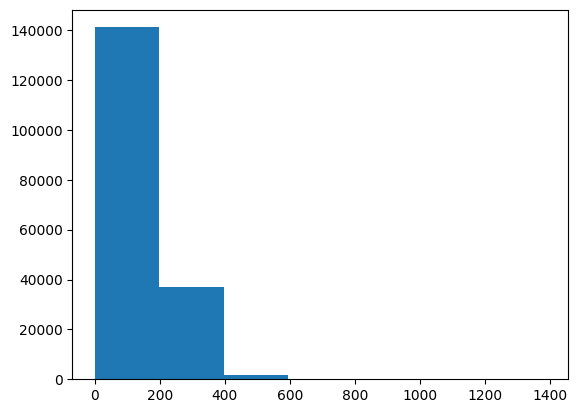

In [56]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [57]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [58]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [59]:
# Create char-level token vectorizer instance
Num_char_tokens = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=Num_char_tokens,
                                output_sequence_length=output_seq_char_len,
                                standardize="lower_and_strip_punctuation",
                                name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [60]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab : {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 most common characters: {char_vocab[-5:]}")

Number of different characters in character vocab : 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 most common characters: ['k', 'x', 'z', 'q', 'j']


In [61]:
# Test out character vectorizer
target_chars = random.choice(train_chars)
print(f"Charified text:\n{target_chars}")
print(f"\nLength of chars: {len(target_chars.split())}")
vectorized_chars = char_vectorizer([target_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
i n   t h e   m o x i b u s t i o n   g r o u p   ,   t h e   w a r m   s u s p e n d i n g   m o x i b u s t i o n   a t   c h a n g q i a n g   (   g v   @   )   w a s   a p p l i e d   .

Length of chars: 78

Vectorized chars:
[[ 4  6  3 13  2 15  7 24  4 22 16  9  3  4  7  6 18  8  7 16 14  3 13  2
  20  5  8 15  9 16  9 14  2  6 10  4  6 18 15  7 24  4 22 16  9  3  4  7
   6  5  3 11 13  5  6 18 26  4  5  6 18 18 21 20  5  9  5 14 14 12  4  2
  10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0 

### Creating a character-level embedding

In [62]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=Num_char_tokens,
                             output_dim=24,
                             mask_zero=False,
                             name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{target_chars}\n")
char_embed_example = char_embed(char_vectorizer([target_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
i n   t h e   m o x i b u s t i o n   g r o u p   ,   t h e   w a r m   s u s p e n d i n g   m o x i b u s t i o n   a t   c h a n g q i a n g   (   g v   @   )   w a s   a p p l i e d   .

Embedded chars (after vectorization and embedding):
[[[-0.04471562 -0.03736268  0.0250198  ...  0.00602194  0.03506947
   -0.02137538]
  [-0.03432371 -0.01124173  0.03152645 ...  0.02250849  0.02833712
   -0.02745404]
  [ 0.04739071  0.00301497  0.00238458 ... -0.02315099  0.0065585
    0.00933957]
  ...
  [ 0.03053233  0.03490928  0.02620156 ... -0.00387052 -0.01752174
   -0.02695394]
  [ 0.03053233  0.03490928  0.02620156 ... -0.00387052 -0.01752174
   -0.02695394]
  [ 0.03053233  0.03490928  0.02620156 ... -0.00387052 -0.01752174
   -0.02695394]]]

Character embedding shape: (1, 290, 24)


### Building a Conv1D model to fit on character embeddings

In [63]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(2096,kernel_size=7,padding="same",activation="relu")(char_embeddings)
x=layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
x = layers.Dense(2096,activation="relu")(x)
x = layers.Dense(2096,activation="relu")(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_3 = tf.keras.Model(inputs,outputs)

model_3.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [64]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 24)           1680      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 2096)         354224    
                                                                 
 global_average_pooling1d_1  (None, 2096)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 2096)              4395

In [65]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((valid_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [66]:
model_3_history = model_3.fit(train_char_dataset,
                             steps_per_epoch=int(0.2*len(train_char_dataset)),
                             epochs=5,
                             validation_data=valid_char_dataset,
                             validation_steps=int(0.2*len(valid_char_dataset)))

Epoch 1/5
1125/1125 [==============================] - 110s 98ms/step - loss: 1.1561 - accuracy: 0.4835 - val_loss: 0.8561 - val_accuracy: 0.6440
Epoch 2/5
1125/1125 [==============================] - 111s 99ms/step - loss: 0.8386 - accuracy: 0.6603 - val_loss: 0.8190 - val_accuracy: 0.6612
Epoch 3/5
1125/1125 [==============================] - 112s 99ms/step - loss: 0.7535 - accuracy: 0.7054 - val_loss: 0.6535 - val_accuracy: 0.7498
Epoch 4/5
1125/1125 [==============================] - 112s 99ms/step - loss: 0.6835 - accuracy: 0.7378 - val_loss: 0.6373 - val_accuracy: 0.7566
Epoch 5/5
1125/1125 [==============================] - 111s 99ms/step - loss: 0.6482 - accuracy: 0.7534 - val_loss: 0.6111 - val_accuracy: 0.7731


In [67]:
model_3.evaluate(valid_char_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.6180 - accuracy: 0.7692


[0.6179519295692444, 0.7691645622253418]

In [68]:
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs

945/945 [==============================] - 20s 21ms/step


array([[1.26331255e-01, 7.19434917e-01, 6.71218634e-02, 3.29224616e-02,
        5.41894548e-02],
       [1.06253169e-01, 8.48843873e-01, 3.93766351e-03, 2.41066143e-02,
        1.68587286e-02],
       [3.34254533e-01, 2.99263690e-02, 1.33074755e-02, 6.17254376e-01,
        5.25723724e-03],
       ...,
       [1.59036263e-05, 1.03534409e-03, 1.86697789e-03, 8.94791447e-06,
        9.97072816e-01],
       [1.85382925e-02, 2.54362375e-01, 6.10080138e-02, 9.07994248e-03,
        6.57011330e-01],
       [1.89103261e-02, 9.28812087e-01, 4.41141473e-03, 3.65957944e-03,
        4.42065522e-02]], dtype=float32)

In [69]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1], dtype=int64)>

In [70]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 76.91645703693897,
 'precision': 0.7679614872951155,
 'recall': 0.7691645703693897,
 'f1-score': 0.7637986268160099}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level model (similar to model_1)
1. Create a character-level model 
1. Combine (using layers.Concatenate) the outputs of 1 and 2
1. Build a series of output layers on top of 3 
1. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [71]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
x = layers.Dense(1024,activation='relu')(token_embeddings)
token_output = layers.Dense(1024,activation='relu')(x)
token_model = tf.keras.Model(inputs=token_inputs,
                            outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                 char_model.output])

# 4. Create output layers - addition of dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200,activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input,char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [72]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][0]']         
  (KerasLayer)                                            24                                      
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0       

In [73]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [74]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

### Combining token and character data into a tf.data dataset

In [75]:
# combine chars and tokens into a dataset
train_chars_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_chars_token_data,train_char_token_labels)) # combine data and labels

# prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_chars_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,valid_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_chars_token_data,val_char_token_labels)) # combine data and labels

# prefetch and batch val data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [76]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [77]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.2 * len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.2 * len(val_char_token_dataset)))

Epoch 1/5
 802/1125 [====================>.........] - ETA: 13s - loss: 0.8385 - accuracy: 0.6750

KeyboardInterrupt: 

In [ ]:
model_4.evaluate(val_char_token_dataset)

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(),depth=15)

In [ ]:
train_line_numbers_one_hot.shape , train_line_numbers_one_hot[:15]

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

In [ ]:
np.percentile(train_df.total_lines, 98)

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

### Building a tribrid embedding model

1. Create a token-level model (similar to model_1)
1. Create a character-level model 
1. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
1. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
1. Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output .
1. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
1. Create an output layer to accept the tribrid embedding and output predicted label probabilities
1. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
x = layers.Dense(1024,activation='relu')(token_embeddings)
token_output = layers.Dense(1024,activation='relu')(x)
token_model = tf.keras.Model(inputs=token_inputs,
                            outputs=token_output)


# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

# 3. Line number Inputs
line_number_inputs = layers.Input(shape=(15,),dtype=tf.int32, name="line_number_input")
x = layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                  outputs=x)

# 4. Total lines Inputs
total_lines_inputs = layers.Input(shape=(20,),dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,char_model.output])

# Addition of dropout
#combined_dropout = layers.Dropout(0.5)(token_char_concat)
z = layers.Dense(256,activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_lines_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5,activation="softmax",name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input 
],outputs = output_layer)

In [ ]:
model_5.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

### Create tribrid embedding datasets and fit tribrid model

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                          train_total_lines_one_hot,
                                                          train_sentences,
                                                           train_chars))

train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_pos_char_token_dataset = train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))

train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              valid_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

In [ ]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                             steps_per_epoch = int(0.2*len(train_pos_char_token_dataset)),
                             epochs=5,
                             validation_data = val_pos_char_token_dataset,
                             validation_steps = int(0.2*len(val_pos_char_token_dataset)))

In [ ]:
model_5.evaluate(val_pos_char_token_dataset)

In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

## Compare model results

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

In [ ]:
all_model_results.sort_values("f1-score", ascending=False)["f1-score"].plot(kind="bar", figsize=(10, 7));

## Save and load best performing model

In [ ]:
model_5.save("skimlit_tribrid_model")

In [ ]:
# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model("./skimlit_tribrid_model")

In [ ]:
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

In [ ]:
loaded_model_results = calculate_results(val_labels_encoded,loaded_preds)
loaded_model_results

## Evaluate model on test dataset

In [ ]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                              test_total_lines_one_hot,
                                                              test_sentences,
                                                              test_chars))

test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data,test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

In [ ]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,verbose=1)
test_preds = tf.argmax(test_pred_probs,axis=1)
test_preds[:10]

In [ ]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

## Find most wrong Predictions

In [ ]:
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]

In [ ]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_pred_probs,axis=1)
test_df["correct"] = test_df["prediction"] == test_df["target"]

test_df.head(10)

In [ ]:
# Find top 10 most wrong samples
top_10_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob",ascending=False)[:10]
top_10_wrong

In [ ]:
# Investigate top wrong preds
for row in top_10_wrong.itertuples():
    _,target,text,line_number,total_lines,prediction,pred_prob,_=row
    print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
    print(f"Text:\n{text}\n")
    print("-----\n")